In [1]:
import os
from os.path import join
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
sns.set(style='ticks')

# Glasses Calibration Analyses
A set of analyses comparing calibration performance across 3 different models of wearable eye-trackers: Tobii Glasses 2, SMI, and Pupil Labs. Each tracker was tested on 3 different subjects. Each subject performed calibration tasks at 3 different distances (1M, 2M, and 3M). At each distance, calibration was tested at 3 different conditons of visual angle offset (-10deg, 0deg, +10deg). 

### Load the combined calibration summaries file
The calibration performance was summarized for each unique subject/glasses/distance/offset condition. These summarized files were combined into a single dataframe 

In [4]:
df = pd.read_table('./allSubjs_calibrationSummary.tsv', sep='\t')
df.head()

,trial,ptIdx,percentValid,centX,centY,centDist,centAngle,RMS,subj,glasses,dist,offset,condition
0,1,15,0.992,872.513,456.424,0.683,48.041,0.113,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
1,2,21,0.996,178.414,736.665,1.135,83.071,0.074,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
2,3,3,0.992,529.483,128.252,0.564,52.494,0.114,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
3,4,13,0.988,537.017,401.570,1.226,69.390,0.123,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg
4,5,25,0.992,862.071,709.513,1.481,76.933,0.087,101,Pupil Labs,1M,0deg,101_PupilLabs_1M_0deg


### average each condition across all calibration points
The dataset above has summarized each individual calibration pt (9 total) for each unique condition. Before any other analyses, average the calibration performance across these 9pts for each condition

In [99]:
df_cond = df.groupby('condition').mean()
df_cond.reset_index(inplace=True)
df_cond.head()

,condition,trial,ptIdx,percentValid,centX,centY,centDist,centAngle,RMS,subj
0,101_PupilLabs_1M_0deg,5,13,0.992444,520.207333,412.236778,1.085667,75.041556,0.107333,101
1,101_PupilLabs_1M_10Ldeg,5,13,0.992000,461.427000,433.862778,1.266556,121.677222,0.159333,101
2,101_PupilLabs_1M_10Rdeg,5,13,0.948333,604.473444,413.189667,1.649778,74.174667,0.129778,101
3,101_PupilLabs_2M_0deg,5,13,0.992444,338.907444,381.451000,1.178778,143.402444,0.080111,101
4,101_PupilLabs_2M_10Ldeg,5,13,0.990111,188.118556,499.280444,1.841111,179.786333,0.102667,101


In [100]:
#split the condition column into separate columns for subj, glasses, dist, and offset
newCols = df_cond['condition'].apply(lambda x: pd.Series(str(x).split('_')))
newCols.rename(columns={0:'subj', 1:'glasses', 2:'dist', 3: 'offset'}, inplace=True)

# drop unecessary or duplicate columns before combining new columns with df_cond
df_cond.drop(['subj', 'trial', 'ptIdx', 'centX', 'centY'], axis=1, inplace=True)
df_cond = pd.concat([newCols, df_cond], axis=1)    

In [101]:
df_cond.head()

,subj,glasses,dist,offset,condition,percentValid,centDist,centAngle,RMS
0,101,PupilLabs,1M,0deg,101_PupilLabs_1M_0deg,0.992444,1.085667,75.041556,0.107333
1,101,PupilLabs,1M,10Ldeg,101_PupilLabs_1M_10Ldeg,0.992000,1.266556,121.677222,0.159333
2,101,PupilLabs,1M,10Rdeg,101_PupilLabs_1M_10Rdeg,0.948333,1.649778,74.174667,0.129778
3,101,PupilLabs,2M,0deg,101_PupilLabs_2M_0deg,0.992444,1.178778,143.402444,0.080111
4,101,PupilLabs,2M,10Ldeg,101_PupilLabs_2M_10Ldeg,0.990111,1.841111,179.786333,0.102667


# Overall accuracy and precision by glasses
Collapsing across distance and offest

In [102]:
df_byGlasses = df_cond.groupby(['subj', 'glasses']).mean()

In [104]:
df_byGlasses

percentValid  centDist   centAngle       RMS
subj glasses                                                
101  PupilLabs      0.980802  1.096914  124.869284  0.107173
     SMI            0.994494  1.136012  251.988790  0.149358
     Tobii          0.994938  1.511951  264.057926  0.292247
102  PupilLabs      0.952049  0.791469  160.897210  0.238877
     SMI            0.977000  1.087000  225.563963  0.274247
     Tobii          0.960617  1.370321  252.716679  0.418210
103  PupilLabs      0.980568  0.641716  174.899741  0.126037
     SMI            0.989346  1.407198  296.890840  0.140235
     Tobii          0.991358  1.393963  263.419321  0.299951

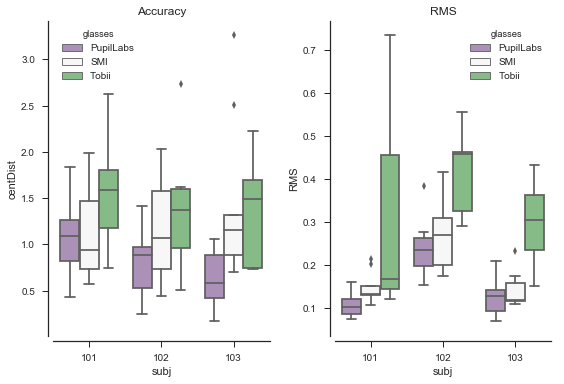

In [105]:
# plot accuracy & RMS
fig, ax = plt.subplots(1,2)

sns.boxplot(x="subj", y="centDist", hue='glasses', ax=ax[0], data=df_cond, palette="PRGn")
sns.despine(offset=5, trim=False)
ax[0].set_title('Accuracy')

sns.boxplot(x="subj", y="RMS", hue='glasses', ax=ax[1], data=df_cond, palette="PRGn")
sns.despine(offset=5, trim=False)
ax[1].set_title('RMS')

plt.tight_layout()

In [106]:
df_byGlasses.sort_index(level=1, inplace=True)

In [107]:
df_byGlasses.reset_index(inplace=True)

In [108]:
df_byGlasses

,subj,glasses,percentValid,centDist,centAngle,RMS
0,101,PupilLabs,0.980802,1.096914,124.869284,0.107173
1,102,PupilLabs,0.952049,0.791469,160.897210,0.238877
2,103,PupilLabs,0.980568,0.641716,174.899741,0.126037
3,101,SMI,0.994494,1.136012,251.988790,0.149358
4,102,SMI,0.977000,1.087000,225.563963,0.274247
5,103,SMI,0.989346,1.407198,296.890840,0.140235
6,101,Tobii,0.994938,1.511951,264.057926,0.292247
7,102,Tobii,0.960617,1.370321,252.716679,0.418210
8,103,Tobii,0.991358,1.393963,263.419321,0.299951


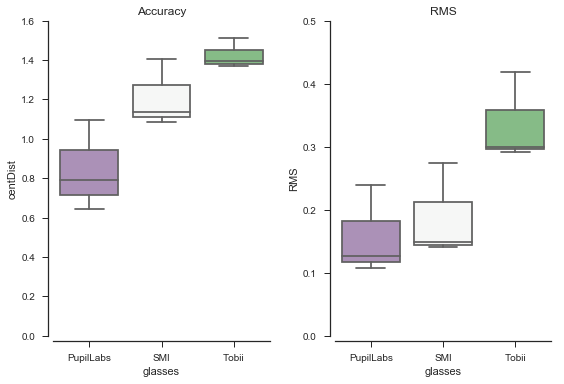

In [109]:
# plot accuracy & RMS
fig, ax = plt.subplots(1,2)

sns.boxplot(x="glasses", y="centDist", ax=ax[0], data=df_byGlasses, palette="PRGn")
sns.despine(offset=5, trim=False)
ax[0].set_title('Accuracy')
ax[0].set_ylim(0,1.6)

sns.boxplot(x="glasses", y="RMS", ax=ax[1], data=df_byGlasses, palette="PRGn")
sns.despine(offset=5, trim=False)
ax[1].set_title('RMS')
ax[1].set_ylim(0,.5)

plt.tight_layout()


## Build a regression model to test influence of experimental vars
Build a model to see if accuracy (centDist) is influenced by:

* subj
* glasses
* dist
* offset
* ptIdx

In [8]:
from statsmodels.formula.api import ols

In [10]:
fullModel = ols("centDist ~ subj + glasses + dist + offset + ptIdx", df).fit()
print(fullModel.summary())

                            OLS Regression Results                            
Dep. Variable:               centDist   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     17.85
Date:                Tue, 30 May 2017   Prob (F-statistic):           1.94e-24
Time:                        14:38:53   Log-Likelihood:                -709.77
No. Observations:                 729   AIC:                             1438.
Df Residuals:                     720   BIC:                             1479.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            5.9304      2.983  

## Look at 0deg offest condition

Test whether calibration accuracy/precision varies across glasses at the 0deg offset condition

In [24]:
df_0deg = df[df.offset == '0deg']
df_0deg.shape

(243, 12)

#### center point (3,3) only 
First, look at calibration accuracy at 0deg offset based only on the center point in the calibration grid

In [26]:
df_0deg_center = df_0deg[df_0deg.ptIdx == 13]
df_0deg_center.shape

(27, 12)